In [7]:
import pandas as pd

df = pd.read_csv('/content/100_Unique_QA_Dataset.csv')

df.head()

,question,answer
0,What is the capital of France?,Paris
1,What is the capital of Germany?,Berlin
2,Who wrote 'To Kill a Mockingbird'?,Harper-Lee
3,What is the largest planet in our solar system?,Jupiter
4,What is the boiling point of water in Celsius?,100


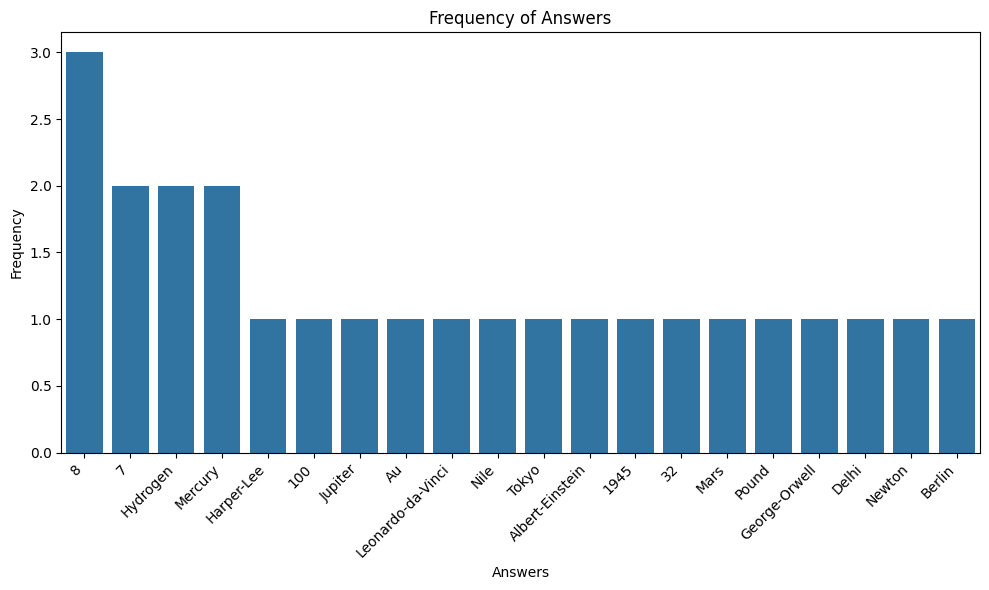

In [45]:


# we can visualize the frequency of answers.

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate answer frequency
answer_counts = df['answer'].value_counts()

# Create a bar plot of the most frequent answers
plt.figure(figsize=(10, 6))
sns.barplot(x=answer_counts.index[:20], y=answer_counts.values[:20])  # Show top 20 answers
plt.xticks(rotation=45, ha='right')
plt.xlabel('Answers')
plt.ylabel('Frequency')
plt.title('Frequency of Answers')
plt.tight_layout()
plt.show()


In [8]:
# tokenize
def tokenize(text):
  text = text.lower()
  text = text.replace('?','')
  text = text.replace("'","")
  return text.split()

In [9]:
tokenize('What is the capital of France?')

['what', 'is', 'the', 'capital', 'of', 'france']

In [10]:
# vocab
vocab = {'<UNK>':0}

In [11]:
def build_vocab(row):
  tokenized_question = tokenize(row['question'])
  tokenized_answer = tokenize(row['answer'])

  merged_tokens = tokenized_question + tokenized_answer

  for token in merged_tokens:

    if token not in vocab:
      vocab[token] = len(vocab)


In [12]:
df.apply(build_vocab, axis=1)

,0
0,None
1,None
2,None
3,None
4,None
...,...
85,None
86,None
87,None
88,None


In [13]:
len(vocab)

324

In [14]:
# convert words to numerical indices
def text_to_indices(text, vocab):

  indexed_text = []

  for token in tokenize(text):

    if token in vocab:
      indexed_text.append(vocab[token])
    else:
      indexed_text.append(vocab['<UNK>'])

  return indexed_text

In [15]:
text_to_indices("What is campusx", vocab)

[1, 2, 0]

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader

In [17]:
class QADataset(Dataset):

  def __init__(self, df, vocab):
    self.df = df
    self.vocab = vocab

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):

    numerical_question = text_to_indices(self.df.iloc[index]['question'], self.vocab)
    numerical_answer = text_to_indices(self.df.iloc[index]['answer'], self.vocab)

    return torch.tensor(numerical_question), torch.tensor(numerical_answer)

In [18]:
dataset = QADataset(df, vocab)

In [19]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [20]:
for question, answer in dataloader:
  print(question, answer[0])

tensor([[ 42,   2,   3, 274, 211, 275]]) tensor([276])
tensor([[42, 18,  2, 62, 63,  3, 64, 18]]) tensor([65])
tensor([[ 42, 137, 118,   3, 247,   5, 248]]) tensor([249])
tensor([[ 1,  2,  3, 24, 25,  5, 26, 19, 27]]) tensor([28])
tensor([[ 42, 117, 118,   3, 119,  94, 120]]) tensor([121])
tensor([[ 42, 174,   2,  62,  39, 175, 176,  12, 177, 178]]) tensor([179])
tensor([[10,  2,  3, 66,  5, 67]]) tensor([68])
tensor([[ 10,  11, 189, 158, 190]]) tensor([191])
tensor([[ 10, 140,   3, 141, 270,  93, 271,   5,   3, 272]]) tensor([273])
tensor([[  1,   2,   3, 146, 147,  19, 148]]) tensor([149])
tensor([[ 78,  79, 261, 151,  14, 262, 153]]) tensor([36])
tensor([[ 1,  2,  3,  4,  5, 73]]) tensor([74])
tensor([[ 1,  2,  3, 69,  5,  3, 70, 71]]) tensor([72])
tensor([[  1,   2,   3,   4,   5, 135]]) tensor([136])
tensor([[ 78,  79, 150, 151,  14, 152, 153]]) tensor([154])
tensor([[78, 79, 80, 81, 82, 83, 84]]) tensor([85])
tensor([[ 42,   2,   3, 210, 137, 168, 211, 169]]) tensor([113])
tensor

In [21]:
import torch.nn as nn

In [46]:
class SimpleRNN(nn.Module):

  def __init__(self, vocab_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim=50)
    self.rnn = nn.RNN(50, 64, batch_first=True)  # Input layer --> 50 neurons , hidden layer ---> 64 neurons , output layer ---> 324 neurons
    self.fc = nn.Linear(64, vocab_size)

  def forward(self, question):
    embedded_question = self.embedding(question)
    hidden, final = self.rnn(embedded_question)
    output = self.fc(final.squeeze(0))

    return output

In [23]:
x = nn.Embedding(324, embedding_dim=50)
y = nn.RNN(50, 64, batch_first=True)
z = nn.Linear(64, 324)

a = dataset[0][0].reshape(1,6)
print("shape of a:", a.shape)
b = x(a)
print("shape of b:", b.shape)
c, d = y(b)
print("shape of c:", c.shape)
print("shape of d:", d.shape)

e = z(d.squeeze(0))

print("shape of e:", e.shape)

shape of a: torch.Size([1, 6])
shape of b: torch.Size([1, 6, 50])
shape of c: torch.Size([1, 6, 64])
shape of d: torch.Size([1, 1, 64])
shape of e: torch.Size([1, 324])


In [36]:
learning_rate = 0.001
epochs = 100

In [37]:
model = SimpleRNN(len(vocab))

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [39]:
# training loop

for epoch in range(epochs):

  total_loss = 0

  for question, answer in dataloader:

    optimizer.zero_grad()

    # forward pass
    output = model(question)

    # loss -> output shape (1,324) - (1)
    loss = criterion(output, answer[0])

    # gradients
    loss.backward()

    # update
    optimizer.step()

    total_loss = total_loss + loss.item()

  print(f"Epoch: {epoch+1}, Loss: {total_loss:4f}")

Epoch: 1, Loss: 522.765242
Epoch: 2, Loss: 452.638643
Epoch: 3, Loss: 372.379324
Epoch: 4, Loss: 314.861908
Epoch: 5, Loss: 265.530198
Epoch: 6, Loss: 219.467151
Epoch: 7, Loss: 176.836740
Epoch: 8, Loss: 138.700994
Epoch: 9, Loss: 107.351591
Epoch: 10, Loss: 82.500177
Epoch: 11, Loss: 63.713177
Epoch: 12, Loss: 50.192888
Epoch: 13, Loss: 40.368991
Epoch: 14, Loss: 32.559331
Epoch: 15, Loss: 26.804999
Epoch: 16, Loss: 22.098011
Epoch: 17, Loss: 18.759971
Epoch: 18, Loss: 15.896437
Epoch: 19, Loss: 13.651953
Epoch: 20, Loss: 11.762408
Epoch: 21, Loss: 10.255190
Epoch: 22, Loss: 8.952885
Epoch: 23, Loss: 7.918299
Epoch: 24, Loss: 7.055583
Epoch: 25, Loss: 6.311311
Epoch: 26, Loss: 5.652840
Epoch: 27, Loss: 5.122566
Epoch: 28, Loss: 4.655989
Epoch: 29, Loss: 4.232768
Epoch: 30, Loss: 3.885042
Epoch: 31, Loss: 3.567326
Epoch: 32, Loss: 3.278818
Epoch: 33, Loss: 3.036316
Epoch: 34, Loss: 2.799703
Epoch: 35, Loss: 2.598610
Epoch: 36, Loss: 2.408485
Epoch: 37, Loss: 2.244825
Epoch: 38, Loss: 

In [40]:
def predict(model, question, threshold=0.5):

  # convert question to numbers
  numerical_question = text_to_indices(question, vocab)

  # tensor
  question_tensor = torch.tensor(numerical_question).unsqueeze(0)

  # send to model
  output = model(question_tensor)

  # convert logits to probs
  probs = torch.nn.functional.softmax(output, dim=1)

  # find index of max prob
  value, index = torch.max(probs, dim=1)

  if value < threshold:
    print("I don't know")

  print(list(vocab.keys())[index])

In [41]:
predict(model, "What is the largest planet in our solar system?")

jupiter


In [42]:
predict(model, "Who was the first female Prime Minister of the UK")

margaretthatcher


In [43]:
list(vocab.keys())[7]

'paris'